# Import Libraries

In [75]:
import os
import torch
import numpy as np
import nltk
import random
from collections import Counter
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# specify date type and device type
dtype = torch.float
device = torch.device("cpu")

# Load Data

In [3]:
def load_data(PATH_TO_FOLDER):
    text = []
    for file in os.listdir(PATH_TO_FOLDER):
        if file.endswith('.txt'):
            with open(str(PATH_TO_FOLDER + file), 'r') as f:
                text.append(f.read().replace('\n', ''))
    return text

In [4]:
PATH_TO_TRAIN_POS = "./aclImdb/train/pos/"
PATH_TO_TRAIN_NEG = "./aclImdb/train/neg/"
PATH_TO_TEST_POS = "./aclImdb/test/pos/"
PATH_TO_TEST_NEG = "./aclImdb/test/neg/"
train_pos = load_data(PATH_TO_TRAIN_POS)
train_neg = load_data(PATH_TO_TRAIN_NEG)
test_pos = load_data(PATH_TO_TEST_POS)
test_neg = load_data(PATH_TO_TEST_NEG)

In [16]:
print(len(train_pos), len(train_neg), len(test_pos), len(test_neg))

12500 12500 12500 12500


In [17]:
train_data = train_pos + train_neg
test = test_pos + test_neg

In [18]:
print(len(train_data), len(test))

20000 25000


In [41]:
y_orig = np.zeros((25000, ), dtype = int)
y_test = np.zeros((25000, ), dtype = int)
y_orig[:12500,] = 1
y_test[:12500,] = 1

In [42]:
# shuffle training dataset and split it into a training set and a validation set
train_data_array = np.asarray(train_data)
y = y_orig
indices = np.arange(len(train_data))
np.random.shuffle(indices)
train_data_array = train_data_array[indices]
y = y[indices]

train = train_data_array[0:20000]
y_train = y[0:20000]
val = train_data_array[20000:25000]
y_val = y[20000:25000]

In [48]:
# train, val, test are lists
# y_train, y_val, y_test are np.array
train = train.tolist()
val = val.tolist()

In [113]:
# ensure that data and label are correspon after shuffling
for i in range(25000):
    assert(train_data_array[i] == train_data[indices[i]])
    assert(y[i] == y_orig[indices[i]])

In [50]:
print(len(train), y_train.shape, type(train), type(y_train))

20000 (20000,) <class 'list'> <class 'numpy.ndarray'>


In [51]:
print(len(val), y_val.shape, type(val), type(y_val))

5000 (5000,) <class 'list'> <class 'numpy.ndarray'>


In [52]:
print(len(test), y_test.shape, type(test), type(y_test))

25000 (25000,) <class 'list'> <class 'numpy.ndarray'>


# Preprocess Data

In [60]:
ENGLISH_STOPS = set(stopwords.words('english'))

In [61]:
def preprocess_data(list_of_text):
    text = []
    for i in range(len(list_of_text)):
        tokens = word_tokenize(list_of_text[i])
        lower_tokens = [token.lower() for token in tokens]
        only_alpha = [word for word in lower_tokens if word.isalpha()]
        no_stops = [word for word in only_alpha if word not in ENGLISH_STOPS]
        wordnet_lemmatizer = WordNetLemmatizer()
        lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in no_stops]
        text.append(lemmatized)
    return text

In [67]:
# list of list of words from each review in train dataset and test dataset
# unigram
train_tokenized = preprocess_data(train)
val_tokenized = preprocess_data(val)
test_tokenized = preprocess_data(test)

In [214]:
x = nltk.ngrams(["are", "you", "a", "pig"], 2)
x = [' '.join(gram) for gram in x]
print(x)

['are you', 'you a', 'a pig']


In [216]:
# bigram
train_tokenized_bigram = []
for i in range(len(train_tokenized)):
    tmp = nltk.ngrams(train_tokenized[i], 2)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = train_tokenized[i] + tmp
    train_tokenized_bigram.append(tmp)

val_tokenized_bigram = []
for i in range(len(val_tokenized)):
    tmp = nltk.ngrams(val_tokenized[i], 2)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = val_tokenized[i] + tmp
    val_tokenized_bigram.append(tmp)

test_tokenized_bigram = []
for i in range(len(test_tokenized)):
    tmp = nltk.ngrams(test_tokenized[i], 2)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = test_tokenized[i] + tmp
    test_tokenized_bigram.append(tmp)

In [243]:
# trigram
train_tokenized_trigram = []
for i in range(len(train_tokenized)):
    tmp = nltk.ngrams(train_tokenized[i], 3)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = train_tokenized[i] + train_tokenized_bigram[i] + tmp
    train_tokenized_trigram.append(tmp)

val_tokenized_trigram = []
for i in range(len(val_tokenized)):
    tmp = nltk.ngrams(val_tokenized[i], 3)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = val_tokenized[i] + val_tokenized_bigram[i] + tmp
    val_tokenized_trigram.append(tmp)

test_tokenized_trigram = []
for i in range(len(test_tokenized)):
    tmp = nltk.ngrams(test_tokenized[i], 3)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = test_tokenized[i] + test_tokenized_bigram[i] + tmp
    test_tokenized_trigram.append(tmp)

In [244]:
# 4-gram
train_tokenized_4gram = []
for i in range(len(train_tokenized)):
    tmp = nltk.ngrams(train_tokenized[i], 4)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = train_tokenized[i] + train_tokenized_bigram[i] + train_tokenized_trigram[i] + tmp
    train_tokenized_4gram.append(tmp)

val_tokenized_4gram = []
for i in range(len(val_tokenized)):
    tmp = nltk.ngrams(val_tokenized[i], 4)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = val_tokenized[i] + val_tokenized_bigram[i] +  val_tokenized_trigram[i] + tmp
    val_tokenized_4gram.append(tmp)

test_tokenized_4gram = []
for i in range(len(test_tokenized)):
    tmp = nltk.ngrams(test_tokenized[i], 4)
    tmp = [' '.join(gram) for gram in tmp]
    tmp = test_tokenized[i] + test_tokenized_bigram[i] + test_tokenized_trigram[i] + tmp
    test_tokenized_4gram.append(tmp)

In [68]:
# get all tokens from unigram train dataset
all_train_tokens = [token for sublist in train_tokenized for token in sublist]
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Total number of tokens in train dataset is 2372538


In [218]:
# get all tokens from unigram + bigram train dataset
all_train_tokens_bigram = [token for sublist in train_tokenized_bigram for token in sublist]
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_bigram)))

Total number of tokens in train dataset is 4725076


In [245]:
# get all tokens from unigram + bigram + trigram train dataset
all_train_tokens_trigram = [token for sublist in train_tokenized_trigram for token in sublist]
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_trigram)))

Total number of tokens in train dataset is 9430152


In [247]:
# get all tokens from unigram + bigram + trigram + 4-gram train dataset
all_train_tokens_4gram = [token for sublist in train_tokenized_4gram for token in sublist]
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_4gram)))

Total number of tokens in train dataset is 18840304


In [248]:
# create the vocabulary of most common 40,000 tokens in the training set
# MAX_VOCAB_SIZE = 5000
# MAX_VOCAB_SIZE = 10000
# MAX_VOCAB_SIZE = 20000
MAX_VOCAB_SIZE = 40000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(MAX_VOCAB_SIZE))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# token2id, id2token = build_vocab(all_train_tokens)
# token2id, id2token = build_vocab(all_train_tokens_bigram)
token2id, id2token = build_vocab(all_train_tokens_trigram)
# token2id, id2token = build_vocab(all_train_tokens_4gram)

In [249]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 7364 ; token intensely
Token intensely; token id 7364


In [250]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

# train_data_indices = token2index_dataset(train_tokenized)
# val_data_indices = token2index_dataset(val_tokenized)
# test_data_indices = token2index_dataset(test_tokenized)

# train_data_indices = token2index_dataset(train_tokenized_bigram)
# val_data_indices = token2index_dataset(val_tokenized_bigram)
# test_data_indices = token2index_dataset(test_tokenized_bigram)

train_data_indices = token2index_dataset(train_tokenized_trigram)
val_data_indices = token2index_dataset(val_tokenized_trigram)
test_data_indices = token2index_dataset(test_tokenized_trigram)

# train_data_indices = token2index_dataset(train_tokenized_4gram)
# val_data_indices = token2index_dataset(val_tokenized_4gram)
# test_data_indices = token2index_dataset(test_tokenized_4gram)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### create PyTorch dataloader

In [251]:
MAX_SENTENCE_LENGTH = 1000

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of imdb tokens 
        @param target_list: list of imdb targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

In [252]:
def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [253]:
# create pytorch dataloader
train_loader = IMDBDataset(train_data_indices, y_train)
val_loader = IMDBDataset(val_data_indices, y_val)
test_loader = IMDBDataset(test_data_indices, y_test)

In [254]:
BATCH_SIZE = 64
train_dataset = IMDBDataset(train_data_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDBDataset(test_data_indices, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [255]:
# for i, (data, lengths, labels) in enumerate(train_loader):
#    print(data)
#    print(labels)
#    break

In [256]:
# define Bag-of-Words model in PyTorch
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
# emb_dim = 50
emb_dim = 100
# emb_dim = 200
# emb_dim = 400
model = BagOfWords(len(id2token), emb_dim)

In [257]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

all_train_acc = []
all_val_acc = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc = test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            all_train_acc.append(train_acc)
            all_val_acc.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))

Epoch: [1/10], Step: [101/313], Train Acc: 84.77, Validation Acc: 81.6
Epoch: [1/10], Step: [201/313], Train Acc: 91.485, Validation Acc: 87.1
Epoch: [1/10], Step: [301/313], Train Acc: 94.275, Validation Acc: 88.36
Epoch: [2/10], Step: [101/313], Train Acc: 95.69, Validation Acc: 88.76
Epoch: [2/10], Step: [201/313], Train Acc: 96.935, Validation Acc: 89.02
Epoch: [2/10], Step: [301/313], Train Acc: 98.36, Validation Acc: 89.46
Epoch: [3/10], Step: [101/313], Train Acc: 98.79, Validation Acc: 89.06
Epoch: [3/10], Step: [201/313], Train Acc: 99.215, Validation Acc: 89.02
Epoch: [3/10], Step: [301/313], Train Acc: 99.535, Validation Acc: 88.54
Epoch: [4/10], Step: [101/313], Train Acc: 99.795, Validation Acc: 88.98
Epoch: [4/10], Step: [201/313], Train Acc: 99.875, Validation Acc: 88.98
Epoch: [4/10], Step: [301/313], Train Acc: 99.97, Validation Acc: 88.76
Epoch: [5/10], Step: [101/313], Train Acc: 99.975, Validation Acc: 88.42
Epoch: [5/10], Step: [201/313], Train Acc: 99.98, Validati

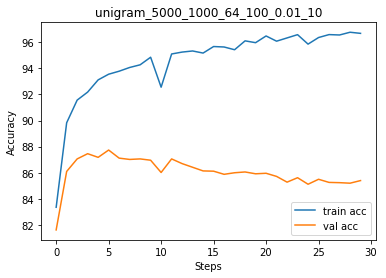

In [152]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_5000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [153]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 85.24
Test Acc 82.828
Maximum training accuracy and maximum validation accuracy are 96.765 and 87.74.


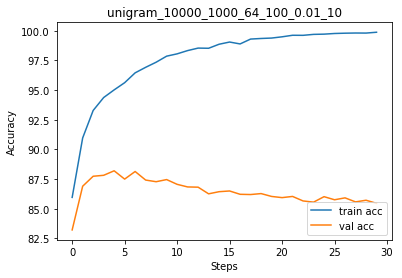

In [164]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_10000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [165]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 85.26
Test Acc 81.928
Maximum training accuracy and maximum validation accuracy are 99.87 and 88.2.


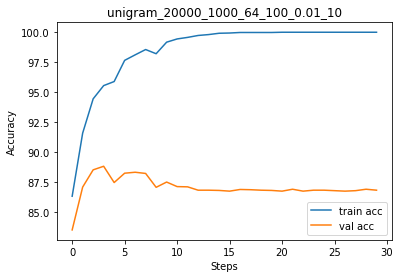

In [141]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_20000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [139]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 86.86
Test Acc 83.508
Maximum training accuracy and maximum validation accuracy are 100.0 and 88.8.


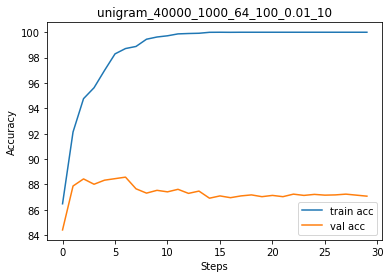

In [176]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_40000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [177]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 87.08
Test Acc 83.86
Maximum training accuracy and maximum validation accuracy are 100.0 and 88.58.


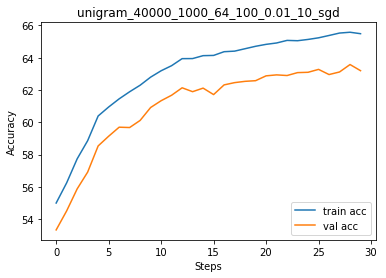

In [183]:
# Using sgd
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_40000_1000_64_100_0.01_10_sgd'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [184]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 63.2
Test Acc 64.008
Maximum training accuracy and maximum validation accuracy are 65.58 and 63.58.


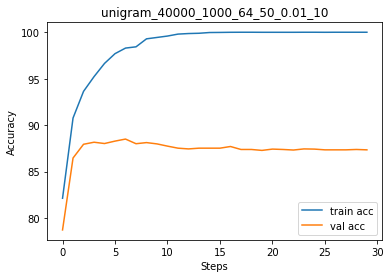

In [190]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_40000_1000_64_50_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [191]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 87.32
Test Acc 83.616
Maximum training accuracy and maximum validation accuracy are 100.0 and 88.5.


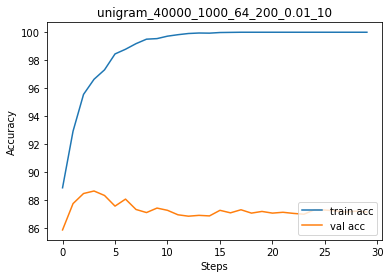

In [196]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_40000_1000_64_200_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [197]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 87.18
Test Acc 83.132
Maximum training accuracy and maximum validation accuracy are 100.0 and 88.66.


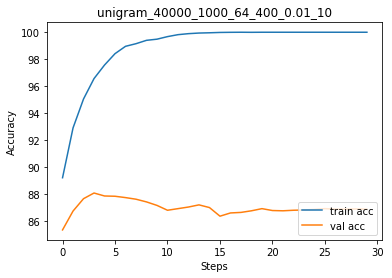

In [202]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'unigram_40000_1000_64_400_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [203]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 86.86
Test Acc 83.204
Maximum training accuracy and maximum validation accuracy are 100.0 and 88.06.


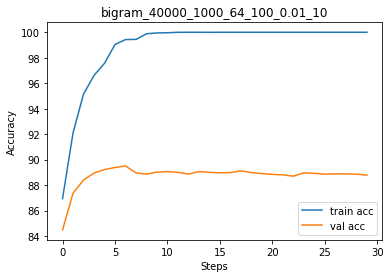

In [241]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'bigram_40000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [242]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 88.88
Test Acc 86.432
Maximum training accuracy and maximum validation accuracy are 100.0 and 89.5.


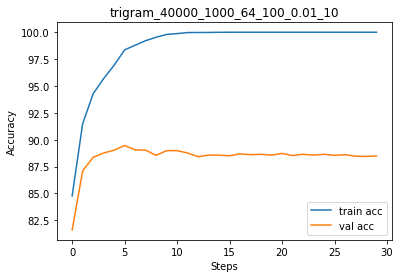

In [258]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = 'trigram_40000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [259]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))

After training for 10 epochs
Val Acc 88.66
Test Acc 86.152
Maximum training accuracy and maximum validation accuracy are 100.0 and 89.46.


In [ ]:
# plot train acc and validation acc
# n-gram, vocabulary_size, max_length, batch_size, embedding_dim, learning_rate, num_epochs
title = '4gram_40000_1000_64_100_0.01_10'
plt.plot(all_train_acc, label='train acc')
plt.plot(all_val_acc, label='val acc')
plt.legend(loc='lower right')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [ ]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))
print("Maximum training accuracy and maximum validation accuracy are {} and {}.".format(max(all_train_acc), max(all_val_acc)))